# Zadanie 8 - Alexnet + Dropout & BatchRegularization
### Aleksandra Jonas, Aleksandra Gronowska, Iwona Christop

## Przygotowanie danych

In [1]:
from IPython.display import Image, display

In [2]:
import sys
import subprocess
import pkg_resources
import numpy as np

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
# Alexnet requires images to be of dim = (227, 227, 3)
newSize = (227,227)

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_train_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = img[:, :, :3]
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255 #normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib

    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    
    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = img[:, :, :3]
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [3]:
# Data load
data_train = load_train_data("./train_test_sw/train_sw")
values_train = data_train['values']
labels_train = data_train['labels']

data_test = load_test_data("./train_test_sw/test_sw")
X_test = data_test['values']
y_test = data_test['labels']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_validate, y_train, y_validate = train_test_split(values_train, labels_train, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_validate_enc = class_le.fit_transform(y_validate)
y_test_enc = class_le.fit_transform(y_test)

In [7]:
class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_validate_enc = class_le.fit_transform(y_validate)
y_test_enc = class_le.fit_transform(y_test)

In [8]:
import tensorflow as tf

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
validation_ds = tf.data.Dataset.from_tensor_slices((X_validate, y_validate_enc))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

In [10]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 820
Test data size: 259
Validation data size: 206


In [11]:
train_ds = (train_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [12]:
from tensorflow import keras

## Dropout

### Do warstw spłaszczonych

In [13]:
model_flat_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
model_flat_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_flat_drop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("alex_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex1 = model_flat_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/1946638494.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex1 = model_flat_drop.fit_generator(


Epoch 1/25


2023-01-06 21:33:12.260921: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - ETA: 0s - loss: 2.2671 - accuracy: 0.1963
Epoch 1: val_accuracy improved from -inf to 0.20312, saving model to alex_1.h5
25/25 [==============================] - 24s 939ms/step - loss: 2.2671 - accuracy: 0.1963 - val_loss: 2.2120 - val_accuracy: 0.2031
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 2.0757 - accuracy: 0.1875
Epoch 2: val_accuracy improved from 0.20312 to 0.28125, saving model to alex_1.h5
25/25 [==============================] - 22s 899ms/step - loss: 2.0757 - accuracy: 0.1875 - val_loss: 1.7334 - val_accuracy: 0.2812
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.7064 - accuracy: 0.2100
Epoch 3: val_accuracy did not improve from 0.28125
25/25 [==============================] - 23s 940ms/step - loss: 1.7064 - accuracy: 0.2100 - val_loss: 1.6128 - val_accuracy: 0.2656
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.6449 - accuracy: 0.2537
Epoch 4: val_accuracy impro

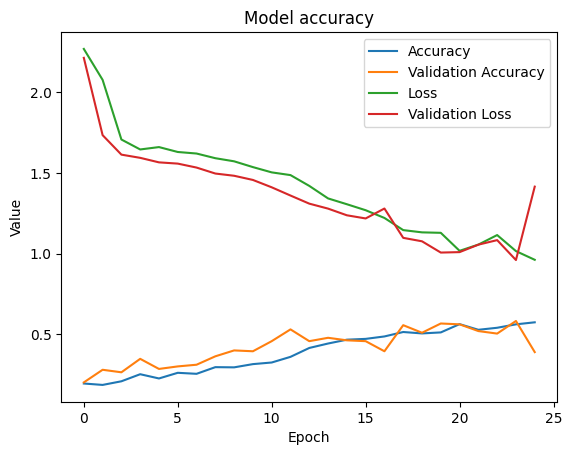

In [16]:
import matplotlib.pyplot as plt
plt.plot(alex1.history["accuracy"])
plt.plot(alex1.history['val_accuracy'])
plt.plot(alex1.history['loss'])
plt.plot(alex1.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [18]:
model_flat_drop.evaluate(test_ds)

8/8 [==============================] - 2s 218ms/step - loss: 1.4086 - accuracy: 0.4141


[1.4086337089538574, 0.4140625]

### Do warstw maxpooling

In [19]:
model_pool_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [20]:
model_pool_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_pool_drop.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 27, 27, 96)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 256)      

In [21]:
checkpoint = ModelCheckpoint("alex_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex2 = model_pool_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/3758035572.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex2 = model_pool_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 2.0517 - accuracy: 0.1963
Epoch 1: val_accuracy improved from -inf to 0.26042, saving model to alex_2.h5
25/25 [==============================] - 24s 926ms/step - loss: 2.0517 - accuracy: 0.1963 - val_loss: 1.8585 - val_accuracy: 0.2604
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.6898 - accuracy: 0.2300
Epoch 2: val_accuracy improved from 0.26042 to 0.30208, saving model to alex_2.h5
25/25 [==============================] - 23s 937ms/step - loss: 1.6898 - accuracy: 0.2300 - val_loss: 1.7242 - val_accuracy: 0.3021
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.6539 - accuracy: 0.2275
Epoch 3: val_accuracy did not improve from 0.30208
25/25 [==============================] - 23s 942ms/step - loss: 1.6539 - accuracy: 0.2275 - val_loss: 1.7515 - val_accuracy: 0.2552
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.2775
Epoch 4: val_accuracy did n

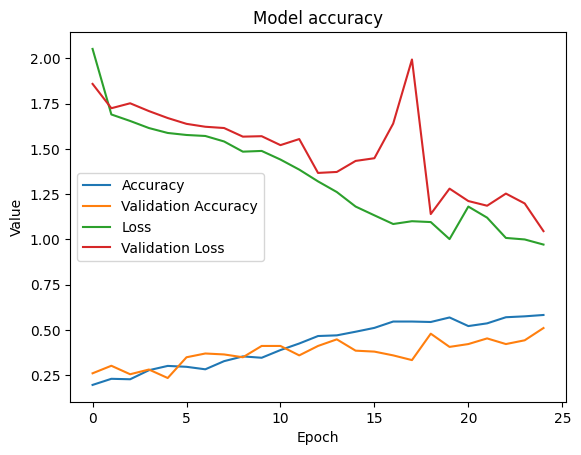

In [22]:
plt.plot(alex2.history["accuracy"])
plt.plot(alex2.history['val_accuracy'])
plt.plot(alex2.history['loss'])
plt.plot(alex2.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [23]:
model_pool_drop.evaluate(test_ds)

8/8 [==============================] - 2s 265ms/step - loss: 1.0271 - accuracy: 0.5391


[1.0271097421646118, 0.5390625]

### Do warstw splotowych

In [24]:
model_conv_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [25]:
model_conv_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_conv_drop.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 dropout_5 (Dropout)         (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 dropout_6 (Dropout)         (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                  

In [26]:
checkpoint = ModelCheckpoint("alex_3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex3 = model_conv_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/3866647797.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex3 = model_conv_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 1.8090 - accuracy: 0.2450
Epoch 1: val_accuracy improved from -inf to 0.21354, saving model to alex_3.h5
25/25 [==============================] - 26s 1s/step - loss: 1.8090 - accuracy: 0.2450 - val_loss: 2.1443 - val_accuracy: 0.2135
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.6573 - accuracy: 0.2738
Epoch 2: val_accuracy improved from 0.21354 to 0.40104, saving model to alex_3.h5
25/25 [==============================] - 25s 1s/step - loss: 1.6573 - accuracy: 0.2738 - val_loss: 2.1381 - val_accuracy: 0.4010
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.5349 - accuracy: 0.3413
Epoch 3: val_accuracy did not improve from 0.40104
25/25 [==============================] - 25s 1s/step - loss: 1.5349 - accuracy: 0.3413 - val_loss: 2.0752 - val_accuracy: 0.2760
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.4963 - accuracy: 0.3688
Epoch 4: val_accuracy did not improv

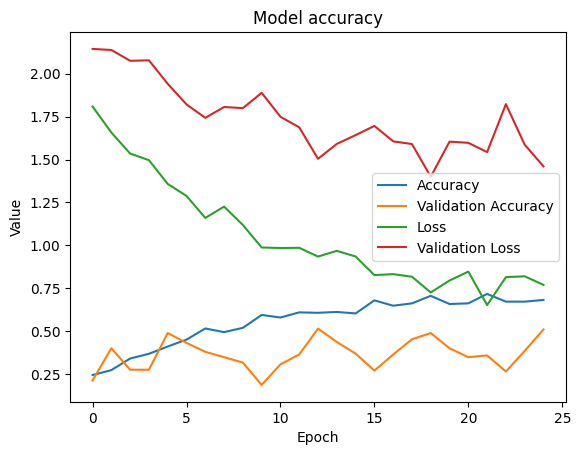

In [27]:
plt.plot(alex3.history["accuracy"])
plt.plot(alex3.history['val_accuracy'])
plt.plot(alex3.history['loss'])
plt.plot(alex3.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [28]:
model_conv_drop.evaluate(test_ds)

8/8 [==============================] - 2s 280ms/step - loss: 1.4843 - accuracy: 0.4570


[1.4843157529830933, 0.45703125]

### Do warstw spłaszczonych i maxpooling

In [29]:
model_flat_pool_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [30]:
model_flat_pool_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_flat_pool_drop.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 256)      0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 13, 13, 256)      

In [31]:
checkpoint = ModelCheckpoint("alex_4.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex4 = model_flat_pool_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/2334869237.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex4 = model_flat_pool_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 2.1044 - accuracy: 0.1750
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to alex_4.h5
25/25 [==============================] - 27s 1s/step - loss: 2.1044 - accuracy: 0.1750 - val_loss: 1.9644 - val_accuracy: 0.2500
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.7691 - accuracy: 0.1875
Epoch 2: val_accuracy did not improve from 0.25000
25/25 [==============================] - 26s 1s/step - loss: 1.7691 - accuracy: 0.1875 - val_loss: 1.8190 - val_accuracy: 0.1979
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.7062 - accuracy: 0.2113
Epoch 3: val_accuracy did not improve from 0.25000
25/25 [==============================] - 27s 1s/step - loss: 1.7062 - accuracy: 0.2113 - val_loss: 1.8115 - val_accuracy: 0.2083
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.6706 - accuracy: 0.2362
Epoch 4: val_accuracy improved from 0.25000 to 0.30208, saving mode

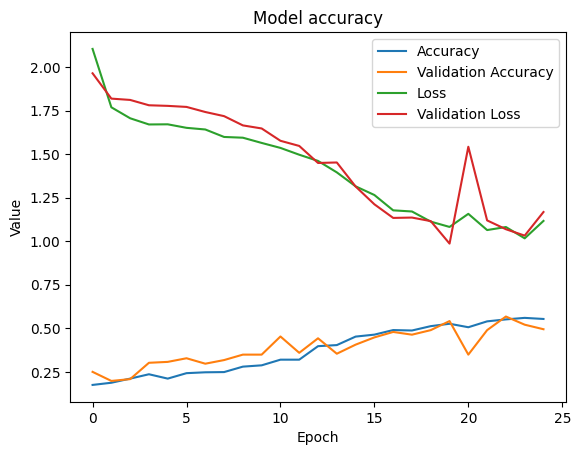

In [32]:
plt.plot(alex4.history["accuracy"])
plt.plot(alex4.history['val_accuracy'])
plt.plot(alex4.history['loss'])
plt.plot(alex4.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [33]:
model_flat_pool_drop.evaluate(test_ds)

8/8 [==============================] - 3s 321ms/step - loss: 1.2209 - accuracy: 0.5000


[1.220850944519043, 0.5]

### Do warstw spłaszczonych i splotowych

In [34]:
model_flat_conv_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [35]:
model_flat_conv_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_flat_conv_drop.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 dropout_15 (Dropout)        (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 dropout_16 (Dropout)        (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 256)      0         
 g2D)                                                 

In [36]:
checkpoint = ModelCheckpoint("alex_5.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex5 = model_flat_conv_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/1544533144.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex5 = model_flat_conv_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 1.8865 - accuracy: 0.2087
Epoch 1: val_accuracy improved from -inf to 0.31771, saving model to alex_5.h5
25/25 [==============================] - 31s 1s/step - loss: 1.8865 - accuracy: 0.2087 - val_loss: 2.1611 - val_accuracy: 0.3177
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.2250
Epoch 2: val_accuracy did not improve from 0.31771
25/25 [==============================] - 33s 1s/step - loss: 1.6987 - accuracy: 0.2250 - val_loss: 2.1324 - val_accuracy: 0.1823
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.6349 - accuracy: 0.2675
Epoch 3: val_accuracy did not improve from 0.31771
25/25 [==============================] - 29s 1s/step - loss: 1.6349 - accuracy: 0.2675 - val_loss: 2.0670 - val_accuracy: 0.3125
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.5613 - accuracy: 0.3212
Epoch 4: val_accuracy improved from 0.31771 to 0.34896, saving mode

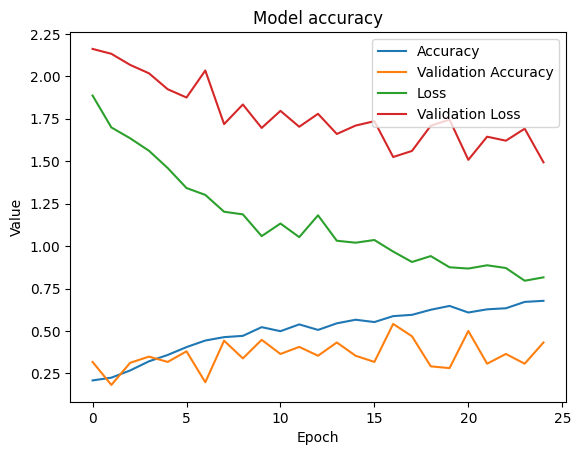

In [37]:
plt.plot(alex5.history["accuracy"])
plt.plot(alex5.history['val_accuracy'])
plt.plot(alex5.history['loss'])
plt.plot(alex5.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [38]:
model_flat_conv_drop.evaluate(test_ds)

8/8 [==============================] - 2s 307ms/step - loss: 1.4823 - accuracy: 0.4531


[1.4823071956634521, 0.453125]

### Do warstw maxpooling i splotowych

In [39]:
model_pool_conv_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [40]:
model_pool_conv_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_pool_conv_drop.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 dropout_22 (Dropout)        (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 dropout_24 (Dropout)        (None, 27, 27, 256)       0         
                                                      

In [41]:
checkpoint = ModelCheckpoint("alex_6.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex6 = model_pool_conv_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/3120705445.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex6 = model_pool_conv_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 1.8171 - accuracy: 0.2288
Epoch 1: val_accuracy improved from -inf to 0.27604, saving model to alex_6.h5
25/25 [==============================] - 29s 1s/step - loss: 1.8171 - accuracy: 0.2288 - val_loss: 2.2332 - val_accuracy: 0.2760
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.2512
Epoch 2: val_accuracy did not improve from 0.27604
25/25 [==============================] - 28s 1s/step - loss: 1.6441 - accuracy: 0.2512 - val_loss: 2.2203 - val_accuracy: 0.1823
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.5645 - accuracy: 0.3013
Epoch 3: val_accuracy did not improve from 0.27604
25/25 [==============================] - 28s 1s/step - loss: 1.5645 - accuracy: 0.3013 - val_loss: 2.1670 - val_accuracy: 0.2240
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.5076 - accuracy: 0.3237
Epoch 4: val_accuracy did not improve from 0.27604
25/25 [=========

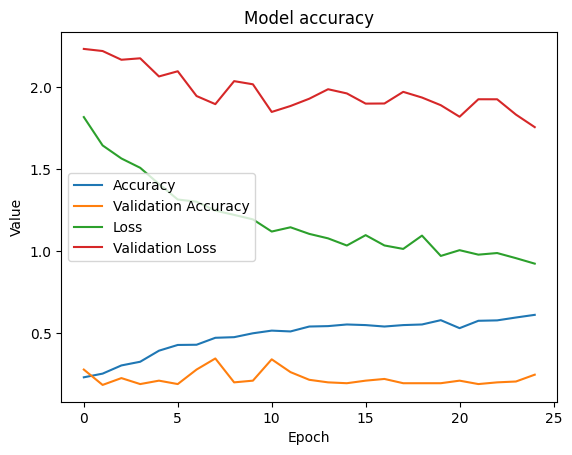

In [42]:
plt.plot(alex6.history["accuracy"])
plt.plot(alex6.history['val_accuracy'])
plt.plot(alex6.history['loss'])
plt.plot(alex6.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [43]:
model_pool_conv_drop.evaluate(test_ds)

8/8 [==============================] - 2s 306ms/step - loss: 1.7711 - accuracy: 0.2227


[1.7710821628570557, 0.22265625]

### Do warstw spłaszczonych, maxpooling i splotowych

In [44]:
model_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Dropout(.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [45]:
model_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_drop.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 dropout_30 (Dropout)        (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 dropout_32 (Dropout)        (None, 27, 27, 256)       0         
                                                      

In [46]:
checkpoint = ModelCheckpoint("alex_7.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex7 = model_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/2699219498.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex7 = model_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 1.9261 - accuracy: 0.2025
Epoch 1: val_accuracy improved from -inf to 0.18229, saving model to alex_7.h5
25/25 [==============================] - 30s 1s/step - loss: 1.9261 - accuracy: 0.2025 - val_loss: 2.2480 - val_accuracy: 0.1823
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.7103 - accuracy: 0.1963
Epoch 2: val_accuracy improved from 0.18229 to 0.18750, saving model to alex_7.h5
25/25 [==============================] - 29s 1s/step - loss: 1.7103 - accuracy: 0.1963 - val_loss: 2.2290 - val_accuracy: 0.1875
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 1.6472 - accuracy: 0.2362
Epoch 3: val_accuracy improved from 0.18750 to 0.19271, saving model to alex_7.h5
25/25 [==============================] - 29s 1s/step - loss: 1.6472 - accuracy: 0.2362 - val_loss: 2.1991 - val_accuracy: 0.1927
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 1.5965 - accuracy: 0.2675
Epoch

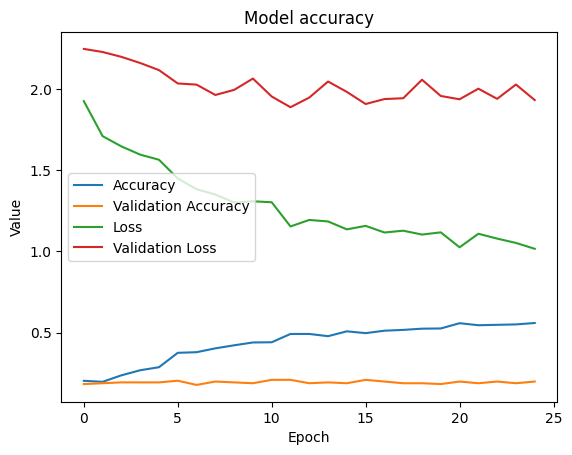

In [47]:
plt.plot(alex7.history["accuracy"])
plt.plot(alex7.history['val_accuracy'])
plt.plot(alex7.history['loss'])
plt.plot(alex7.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [48]:
model_drop.evaluate(test_ds)

8/8 [==============================] - 4s 534ms/step - loss: 1.9357 - accuracy: 0.2070


[1.9356722831726074, 0.20703125]

## Batch Regularization

### Bez dropoutu

In [49]:
model_batch = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [50]:
model_batch.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_batch.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [51]:
checkpoint = ModelCheckpoint("alex_8.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex8 = model_batch.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/2334374023.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex8 = model_batch.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 3.5162 - accuracy: 0.4512
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to alex_8.h5
25/25 [==============================] - 51s 2s/step - loss: 3.5162 - accuracy: 0.4512 - val_loss: 2.1169 - val_accuracy: 0.2083
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.7425
Epoch 2: val_accuracy did not improve from 0.20833
25/25 [==============================] - 52s 2s/step - loss: 0.6702 - accuracy: 0.7425 - val_loss: 2.1916 - val_accuracy: 0.1771
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8637
Epoch 3: val_accuracy did not improve from 0.20833
25/25 [==============================] - 52s 2s/step - loss: 0.3823 - accuracy: 0.8637 - val_loss: 2.5290 - val_accuracy: 0.1823
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9388
Epoch 4: val_accuracy did not improve from 0.20833
25/25 [=========

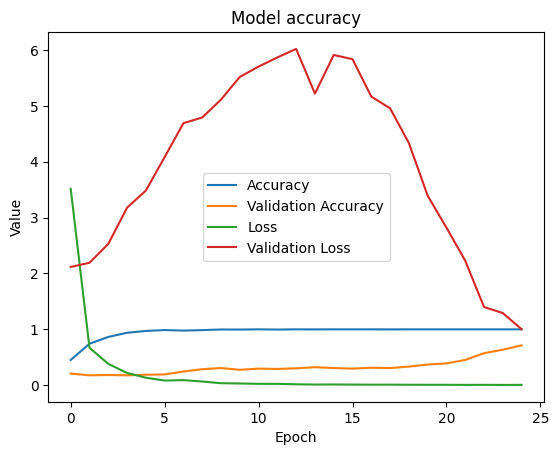

In [52]:
plt.plot(alex8.history["accuracy"])
plt.plot(alex8.history['val_accuracy'])
plt.plot(alex8.history['loss'])
plt.plot(alex8.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [53]:
model_batch.evaluate(test_ds)

8/8 [==============================] - 4s 557ms/step - loss: 0.8515 - accuracy: 0.7383


[0.8515095114707947, 0.73828125]

### Z dropoutem

In [54]:
model_batch_drop = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [55]:
model_batch_drop.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model_batch_drop.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [56]:
checkpoint = ModelCheckpoint("alex_9.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex9 = model_batch_drop.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

Epoch 1/25


/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_13671/3373435413.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex9 = model_batch_drop.fit_generator(


25/25 [==============================] - ETA: 0s - loss: 5.1567 - accuracy: 0.3462
Epoch 1: val_accuracy improved from -inf to 0.39583, saving model to alex_9.h5
25/25 [==============================] - 53s 2s/step - loss: 5.1567 - accuracy: 0.3462 - val_loss: 1.8424 - val_accuracy: 0.3958
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 1.5037 - accuracy: 0.5688
Epoch 2: val_accuracy did not improve from 0.39583
25/25 [==============================] - 48s 2s/step - loss: 1.5037 - accuracy: 0.5688 - val_loss: 2.2144 - val_accuracy: 0.2396
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.9447 - accuracy: 0.6812
Epoch 3: val_accuracy did not improve from 0.39583
25/25 [==============================] - 45s 2s/step - loss: 0.9447 - accuracy: 0.6812 - val_loss: 3.3665 - val_accuracy: 0.1823
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.7950 - accuracy: 0.7287
Epoch 4: val_accuracy did not improve from 0.39583
25/25 [=========

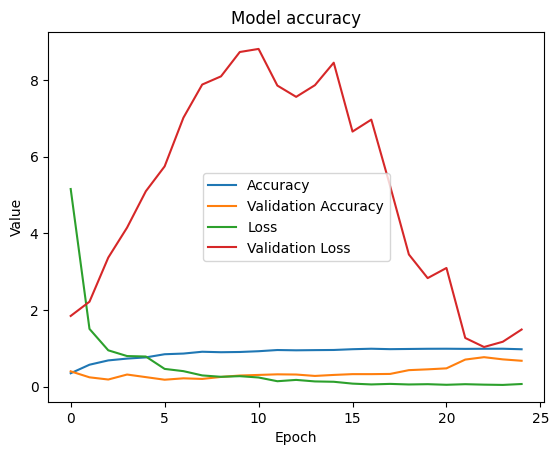

In [57]:
plt.plot(alex9.history["accuracy"])
plt.plot(alex9.history['val_accuracy'])
plt.plot(alex9.history['loss'])
plt.plot(alex9.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [58]:
model_batch_drop.evaluate(test_ds)

8/8 [==============================] - 4s 493ms/step - loss: 1.3864 - accuracy: 0.6953


[1.386448621749878, 0.6953125]